In [60]:
!pip install contextily rasterio elevation srtm.py scipy

import contextily as ctx
import matplotlib.pyplot as plt
import numpy as np
import srtm
import os
from scipy.interpolate import griddata
from PIL import Image
import cv2

In [285]:
def fetch_osm_image(lat, lon, zoom=12, output_path='./satellite_image.png'):
    fig, ax = plt.subplots(figsize=(10, 10))
    delta = 0.05
    extent = (lon - delta, lat - delta, lon + delta, lat + delta)
    ax.set_xlim(extent[0], extent[2])
    ax.set_ylim(extent[1], extent[3])

    ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.Esri.WorldImagery, zoom=zoom, attribution=None)
    plt.axis('off')
    if not os.path.exists(os.path.dirname(output_path)):
        os.makedirs(os.path.dirname(output_path))
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()

    if os.path.exists(output_path):
        return plt.imread(output_path), extent

def fetch_elevation_data(lat, lon, size):
    delta = 0.05
    lats = np.linspace(lat - delta, lat + delta, size[0])
    lons = np.linspace(lon - delta, lon + delta, size[1])
    dem_data = np.zeros(size)

    elevation_data = srtm.get_data()

    for i, lat_val in enumerate(lats):
        for j, lon_val in enumerate(lons):
            elevation = elevation_data.get_elevation(lat_val, lon_val)
            if elevation is None:
                elevation = np.nan
            dem_data[i, j] = elevation

    dem_data = np.flipud(dem_data)

    x, y = np.meshgrid(lons, lats)
    points = np.array([x[~np.isnan(dem_data)], y[~np.isnan(dem_data)]]).T
    values = dem_data[~np.isnan(dem_data)]
    dem_data = griddata(points, values, (x, y), method='linear')

    return dem_data, (lons[0], lats[-1], lons[-1], lats[0])

def plot_images(lat, lon, s):
    satellite_image, sat_extent = fetch_osm_image(lat, lon)
    dem_data, dem_extent = fetch_elevation_data(lat, lon, size=(s,s))

    #fig, axes = plt.subplots(1, 2, figsize=(15, 7.5))

    #im = axes[0].imshow(dem_data, cmap='gray_r', extent=dem_extent)
    #axes[0].set_title('DEM')

    #cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])  # [left, bottom, width, height]
    #fig.colorbar(im, cax=cbar_ax, orientation='horizontal')


    #axes[1].imshow(satellite_image, extent=sat_extent)
    #axes[1].set_title('Satellite Image')

    #plt.show()

    return satellite_image, dem_data

#if __name__ == "__main__":
#  lat = 46.190843
#  lon = 10.576355
#
#  plot_images(lat, lon, 600)

In [265]:
def gen_data(iter, path, shape=128):
  def reorder_channels(image):
    return np.transpose(image, (2, 0, 1))

  def resize_image(image, size=(128, 128)):
      resized_image = cv2.resize(image, size, interpolation=cv2.INTER_LINEAR)
      return resized_image
  arr_im = []
  arr_dem = []
  arr_size = []
  size=256

  for i in range(iter):
    ###
    lat = 46.8 + np.random.uniform(-1.0, 1.0)
    lon = 10.4 + np.random.uniform(-1.0, 1.0)
    ###
    satellite_image, dem_data = plot_images(lat, lon, shape)

    satellite_image = satellite_image[:, :, :3]
    satellite_image = resize_image(satellite_image)
    satellite_image = reorder_channels(satellite_image)
    dem_data = np.expand_dims(dem_data, axis=0)
    size = size

    arr_im.append(satellite_image)
    arr_dem.append(dem_data)
    arr_size.append(size)

  np.savez(path, dem=arr_dem, rgb=arr_im, size=arr_size)


In [ ]:
gen_data(250, path='/content/test.npz')

(1, 128, 128)


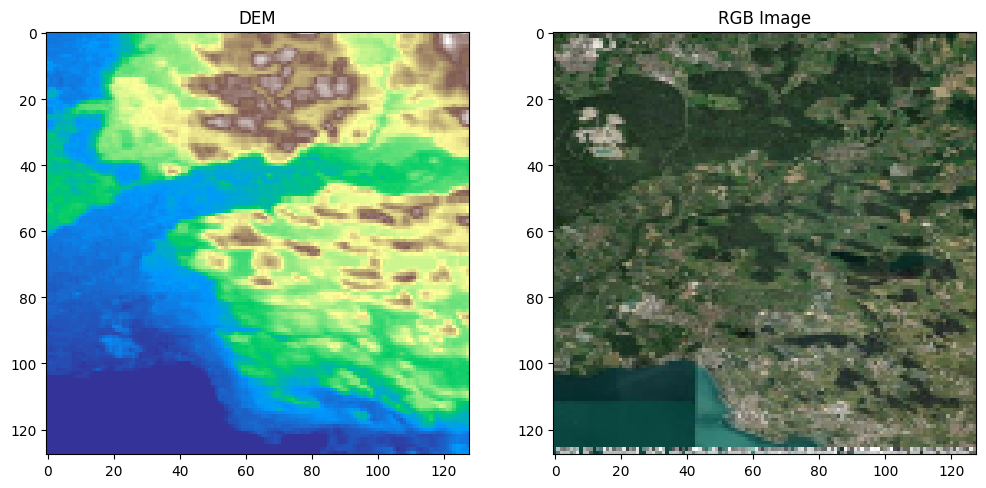

In [270]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load('/content/train.npz')
indx = 122
dem = data['dem'][indx]
rgb = data['rgb'][indx]
data['rgb'][indx].shape
print(dem.shape)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(dem[0], cmap='terrain')
axes[0].set_title("DEM")

axes[1].imshow(rgb.transpose(1, 2, 0))
axes[1].set_title("RGB Image")

plt.show()